In [1]:
import os
import sys
from collections import Counter
from typing import List, Tuple, Type
from glob import glob
import pandas as pd
from scipy import io
import wfdb
import numpy as np
from tqdm import tqdm
import pickle
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [2]:
def process_label(df: pd.DataFrame) -> np.ndarray:
    labels = np.zeros([df.shape[0], 9])

    labels_first = df.First_label.values
    labels_second = df.Second_label.values
    labels_third = df.Third_label.values

    # labels = [1 - 9] -> label_index = [0 - 8]
    for i in range(df.shape[0]):
        # Validate: normal labeled sample has no other labels.
        if labels_first[i] == 1:
            assert(np.isnan(labels_second[i]) \
                   and np.isnan(labels_third[i]))

        labels[i, labels_first[i] - 1] = 1
        if not np.isnan(labels_second[i]):
            labels[i, int(labels_second[i]) - 1] = 1
        if not np.isnan(labels_third[i]):
            labels[i, int(labels_third[i]) - 1] = 1
    return labels

In [3]:
load_dir = '/home/gridsan/ybo/advaug/data/cpsc2018/raw'
cpsc_reference = "TrainingSet3/REFERENCE.csv"
reference_file = os.path.join(load_dir, cpsc_reference)
filelist_df = pd.read_csv(reference_file)
signals = filelist_df.Recording.values
labels = process_label(filelist_df)

In [4]:
msss_1 = MultilabelStratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=1)

for train_idx, test_idx in msss_1.split(signals, labels):
    pass

msss_2 = MultilabelStratifiedShuffleSplit(
    n_splits=1, test_size=0.5, random_state=1)

for valid_idx, test_idx in msss_2.split(signals[test_idx], labels[test_idx]):
    pass

f_train, f_valid, f_test =\
    signals[train_idx], signals[valid_idx], signals[test_idx]
y_train, y_valid, y_test =\
    labels[train_idx], labels[valid_idx], labels[test_idx]

In [5]:
def open_ecg_files(target_files):
    signals = []
    for target_file in tqdm(target_files):
        target_path = os.path.join(load_dir, "*", target_file+".mat")
        mat_file = glob(target_path)[0]
        record = io.loadmat(mat_file) # [`Sex`, `Age`, `ECG`]
        signals.append(record["ECG"][0][0][2]) # num_lead = 12, sequence_length
    return signals

In [6]:
X_train = open_ecg_files(f_train)
X_val = open_ecg_files(f_valid)
X_test = open_ecg_files(f_test)

100%|██████████| 690/690 [00:15<00:00, 43.42it/s]


In [9]:
def align_signal_length(signals):
    aligned_signals = []
    for signal in signals:
        signal_length = signal.shape[-1]
        if signal_length > 5000:
            signal = signal[:,:5000]
        elif signal_length < 5000:
            pad_length = 5000 - signal_length
            pad = np.zeros([pad_length, signal.shape[1]])
            signal = np.concatenate([pad, signal], axis=0)
        aligned_signals.append(signal)
#     aligned_signals = np.stack(aligned_signals)
    return aligned_signals

In [10]:
X_train_aligned = align_signal_length(X_train)
X_val_aligned = align_signal_length(X_val)
X_test_aligned = align_signal_length(X_test)

In [27]:
seed = 2
save_path = "/home/gridsan/ybo/advaug/data/cpsc2018/seed{}".format(seed)
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [26]:
with open("/home/gridsan/ybo/advaug/data/cpsc2018/train.pkl",'wb') as f:
    pickle.dump(X_train_aligned,f)
with open("/home/gridsan/ybo/advaug/data/cpsc2018/val.pkl",'wb') as f:
    pickle.dump(X_val_aligned,f)
with open("/home/gridsan/ybo/advaug/data/cpsc2018/test.pkl",'wb') as f:
    pickle.dump(X_test_aligned,f)

FileNotFoundError: [Errno 2] No such file or directory: '/home/gridsan/ybo/advaug/data/cpsc2018/seed2/train.pkl'

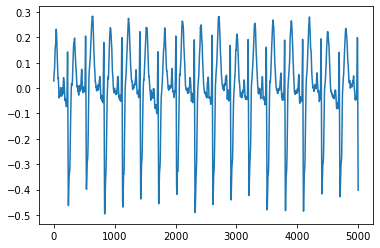

In [17]:
from matplotlib import pyplot as plt

plt.plot(X_train_aligned[0][0])

In [7]:
# with open("/home/gridsan/ybo/CLOCS/data/chapman/contrastive_ss/leads_12/frames_phases_chapman.pkl",'rb') as f:
#             input_array = pickle.load(f)
with open("/home/gridsan/ybo/CLOCS/data/chapman/contrastive_ss/leads_12/labels_phases_chapman.pkl",'rb') as f:
            labels_array = pickle.load(f)

In [10]:
x = input_array['ecg'][1]['train']['All Terms']
y = labels_array['ecg'][1]['train']['All Terms']
y

array([[0, 0, 0, ..., 0, 0, 0],
       [2, 2, 2, ..., 2, 2, 2],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [3, 3, 3, ..., 3, 3, 3],
       [1, 1, 1, ..., 1, 1, 1]])

In [13]:
from scipy.signal import resample
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
enc = LabelEncoder()

In [26]:
dataset = 'chapman'
basepath = '/home/gridsan/ybo/CLOCS/data/chapman/'
trial = 'contrastive_ms' #'contrastive_ss' # '' | 'contrastive_ms' | 'contrastive_ml' | 'contrastive_msml' | 'contrastive_ss'

files = os.listdir(os.path.join(basepath,'ECGDataDenoised'))
database = pd.read_csv(os.path.join(basepath,'Diagnostics.csv'))
dates = database['FileName'].str.split('_',expand=True).iloc[:,1]
dates.name = 'Dates'
dates = pd.to_datetime(dates)
database_with_dates = pd.concat((database,dates),1)
#""" Unique Dates in Database """
#enc.fit(dates)

""" Combine Rhythm Labels """
old_rhythms = ['AF','SVT','ST','AT','AVNRT','AVRT','SAAWR','SI','SA']
new_rhythms = ['AFIB','GSVT','GSVT','GSVT','GSVT','GSVT','GSVT','SR','SR']
database_with_dates['Rhythm'] = database_with_dates['Rhythm'].replace(old_rhythms,new_rhythms)
unique_labels = database_with_dates['Rhythm'].value_counts().index.tolist()
enc.fit(unique_labels)

""" Combine Dates """
def combine_dates(date):
    new_dates = ['All Terms']#use this for continual learning dataset ['Term 1','Term 2','Term 3']
    cutoff_dates = ['2019-01-01']##use this for continual learning dataset ['2018-01-16','2018-02-09','2018-12-30']
    cutoff_dates = [pd.Timestamp(date) for date in cutoff_dates]
    for t,cutoff_date in enumerate(cutoff_dates):
        if date < cutoff_date:
            new_date = new_dates[t]
            break
    return new_date
database_with_dates['Dates'] = database_with_dates['Dates'].apply(combine_dates)

#%%
""" Look at Label Composition """
#""" GroupBy output can be treated as an interable """
groupby_dates = database_with_dates.groupby('Dates')
groupby_dates['Rhythm'].value_counts()

/state/partition1/slurm_tmp/19172587.0.0/ipykernel_60356/1335082236.py:10: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  database_with_dates = pd.concat((database,dates),1)


Dates      Rhythm
All Terms  SB        3889
           GSVT      2307
           AFIB      2225
           SR        2225
Name: Rhythm, dtype: int64

In [32]:
phases = ['train','val','test']
phase_fractions = [0.8, 0.1, 0.1]
phase_fractions_dict = dict(zip(phases,phase_fractions))

term_phase_patients = dict()
term = "All Terms"
term_phase_patients[term] = dict()
term_patients = database_with_dates['FileName'][database_with_dates['Dates'] == term]
random_term_patients = term_patients.sample(frac=1,random_state=0)
start = 0
for phase,fraction in phase_fractions_dict.items():
    if phase == 'test':
        phase_patients = random_term_patients.iloc[start:].tolist() #to avoid missing last patient due to rounding
    else:
        npatients = int(fraction*len(term_patients))
        phase_patients = random_term_patients.iloc[start:start+npatients].tolist()
    term_phase_patients[term][phase] = phase_patients
    start += npatients

In [70]:
random_term_patients

6121    MUSE_20180113_135045_85000
5173    MUSE_20180113_075515_49000
7052    MUSE_20180113_131421_44000
3759    MUSE_20180209_121003_67000
6526    MUSE_20180209_173904_56000
                   ...            
9225    MUSE_20180113_174454_52000
4859    MUSE_20180112_124508_91000
3264    MUSE_20180118_131538_09000
9845    MUSE_20180113_122543_14000
2732    MUSE_20180210_122936_38000
Name: FileName, Length: 10646, dtype: object

In [41]:
sampling_rate = 500
modality_list = ['ecg']
fraction_list = [1]
leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
desired_leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
inputs_dict = dict()
outputs_dict = dict()
pids = dict()

for phase in phases:
    current_patients = term_phase_patients[term][phase]
    current_inputs = []
    current_outputs = []
    current_pids = []
    for patient in tqdm(current_patients):
        filename = patient + '.csv'
        data = pd.read_csv(os.path.join(basepath,'ECGDataDenoised',filename)) #SxL
        
        resampling_length = 5000
        data_resampled = resample(data,resampling_length)
        data_resampled = data_resampled.T #12x2500
        lead_indices = np.where(np.in1d(leads,desired_leads))[0]
        data_resampled = data_resampled[lead_indices,:] #12x2500
        
        label = database_with_dates['Rhythm'][database_with_dates['FileName']==patient]
        encoded_label = enc.transform(label).item()

        current_inputs.append(data_resampled) #might need to change to '.extend' instead of '.append' to end up with 2D matrix at the end. 
        current_outputs.append([encoded_label for _ in range(data_resampled.shape[0])])
        current_pids.append([patient for _ in range(data_resampled.shape[0])])
        break
    inputs_dict[phase] = np.array(current_inputs)
    outputs_dict[phase] = np.array(current_outputs)
    pids[phase] = np.array(current_pids)

  0%|          | 0/2130 [00:00<?, ?it/s]


In [52]:
save_path = "/home/gridsan/ybo/advaug/data/chapman/"
inputs_dict['train'].dump(os.path.join(save_path, "X_train.npy"), protocol=4)

In [54]:
y = np.load("/home/gridsan/ybo/advaug/data/chapman/y_train.npy", allow_pickle=True)
x = np.load("/home/gridsan/ybo/advaug/data/chapman/X_train.npy", allow_pickle=True)

(1, 12, 5000)

In [63]:
g = np.empty([0, 12, 5000])
g = np.append(g, x, axis=0)
g = np.append(g, x, axis=0)
g.shape

(2, 12, 5000)

In [72]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from itertools import repeat

In [115]:
class Normalize: 
    def __call__(self, x):
        if isinstance(x, np.ndarray):
            x = (x - np.min(x))/(np.max(x) - np.min(x) + 1e-8)
        elif isinstance(x,torch.Tensor):
            x = (x - torch.min(x))/(torch.max(x) - torch.min(x) + 1e-8)
        return x
    
class ToTensor1D(object):
    def __call__(self, sample):
        return torch.from_numpy(sample)

In [116]:
class CollatedTransform:
    """Adds callable base class to implement different transformation pipelines."""

    def __init__(self, augmentations):
        self.augmentations = augmentations.split("_")
        self.transform = transforms.Compose([])

        if 'gaussian' in self.augmentations:
            self.transform = transforms.Compose([self.transform, GaussianNoise])

        self.transform = transforms.Compose([self.transform, 
                                            ToTensor1D(),
                                            Normalize()])

    def __call__(self, x):
        return self.transform(x)

    def __repr__(self):
        return str(self.transform)

In [139]:
class DatasetWrapper(Dataset):

    def __init__(self, db_dir, trial, phase, seed, positive_pairing=None, augmentations=None, nleads=12):
        self.db_dir = db_dir
        self.positive_pairing = positive_pairing
        self.transform = CollatedTransform(augmentations)
        self.normalize = CollatedTransform("_")
        self.nleads = nleads
        self.trial = trial
        self.seed = seed 
        self.phase = phase

        self.load_data()

    def load_data(self):
        self.X = np.load(os.path.join(self.db_dir, "seed{}/X_{}.npy".format(self.seed, self.phase)), allow_pickle=True)
        self.y = np.load(os.path.join(self.db_dir, "seed{}/y_{}.npy".format(self.seed, self.phase)), allow_pickle=True)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample, label = self.X[idx], self.y[idx]

        if self.trial == 'transfer':
            return self.normalize(sample), label

        elif self.trial == "pretrain":
            nsamples = sample.shape[-1]
            if self.positive_pairing == 'CMSC': 
                combined_sample = torch.empty(self.nleads, nsamples, 2)
            elif self.positive_pairing == 'CMLC': 
                combined_sample = torch.empty(1, nsamples, self.nleads)
            elif self.positive_pairing == 'CMSMLC': 
                combined_sample = torch.empty(self.nleads, nsamples, 2)
            elif self.positive_pairing == 'PCLR': 
                combined_sample = torch.empty(self.nleads, nsamples, 2)
            else: 
                combined_sample = torch.empty(self.nleads, nsamples, 2)
                combined_sample[:,:,0] = self.normalize(sample)
                combined_sample[:,:,1] = self.transform(sample)
            
            return combined_sample, label

In [132]:
d = DatasetWrapper(db_dir="/home/gridsan/ybo/advaug/data/chapman", trial="transfer", phase="train", seed=1, positive_pairing=None, augmentations="normalize", nleads=12)

In [133]:
sample, label = d.__getitem__(0)

In [145]:
test = np.empty([0, 12, 5000])
test = np.append(test, sample)
test.shape

(60000,)

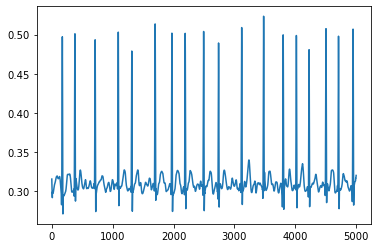

In [134]:
from matplotlib import pyplot as plt

plt.plot(sample[0])
plt.show()

In [140]:
from torch.utils.data import DataLoader, random_split

from pytorch_lightning import LightningDataModule, LightningModule, Trainer
import pytorch_lightning as pl

class ECGDataModule(LightningDataModule):

    def __init__(self, db_dir, batch_size, trial, seed, positive_pairing, augmentations, nleads, do_test=False):
        super().__init__()
        self.data_train = DatasetWrapper(db_dir, trial, "train", seed, positive_pairing=positive_pairing, augmentations=augmentations, nleads=nleads)
        self.data_val = DatasetWrapper(db_dir, trial, "val", seed, positive_pairing=positive_pairing, augmentations=augmentations, nleads=nleads)
        if do_test:
            self.data_test = DatasetWrapper(db_dir, trial, "test", seed, positive_pairing=positive_pairing, augmentations=augmentations, nleads=nleads)

        self.batch_size = batch_size
 
    def train_dataloader(self):
        '''returns training dataloader'''
        return DataLoader(self.data_train, batch_size=self.batch_size)

    def val_dataloader(self):
        '''returns validation dataloader'''
        return DataLoader(self.data_val, batch_size=self.batch_size)

    def test_dataloader(self):
        '''returns test dataloader'''
        return DataLoader(self.data_test, batch_size=self.batch_size)

In [141]:
datamodule = ECGDataModule(db_dir="/home/gridsan/ybo/advaug/data/chapman", batch_size=32, trial="transfer", seed=1, positive_pairing=None, augmentations="normalize", nleads=12)